# Knowledge Graph Embeddings

In [16]:
from rdflib import Graph, Namespace
from rdflib.namespace import RDF
import pandas as pd
import pykeen
from pykeen.pipeline import pipeline
from pykeen.triples import TriplesFactory
import os
import numpy as np
import torch
from collections import defaultdict
from sklearn.model_selection import train_test_split
from pykeen.models import Model
import re

In [17]:
os.getcwd()

'c:\\mahmoud uni\\TU\\SS2024\\KGs\\Portfolio'

## Load Knowledge Graph

In [18]:
BASE = Namespace("http://www.semanticweb.org/mabsa/ontologies/2024/10/ea-fc-ontology/")
g = Graph()
ontology_file = r"dataset\EA_FC_knowledge_graph.ttl" 
g.parse(ontology_file, format="ttl")

<Graph identifier=N058aaa31c70c4c0faa27cb80900d5e46 (<class 'rdflib.graph.Graph'>)>

In [19]:
# Extract Entities
players = set(g.subjects(RDF.type, BASE.Player))
clubs = set(g.subjects(RDF.type, BASE.Club))
leagues = set(g.subjects(RDF.type, BASE.League))

print(f"Total Players: {len(players)}")
print(f"Total Clubs: {len(clubs)}")
print(f"Total Leagues: {len(leagues)}")

Total Players: 8672
Total Clubs: 2163
Total Leagues: 175


# Split Preperation

In [20]:
# Player extracting unique ID for each player
unique_player_ids = set()
player_id_to_triples = defaultdict(list)


players = list(g.subjects(RDF.type, BASE.Player)) # player nodes

# mapping players to unique id
player_to_id = {}

for player in players:
    for pred, obj in g.predicate_objects(player):
        if pred == BASE.player_id:
            player_id_full = str(obj)  
            player_unique_id = player_id_full.split('_')[0] # full ID e.g., '139068_21' -> wird zu 139068
            player_to_id[player] = player_unique_id
            unique_player_ids.add(player_unique_id)

for s, p, o in g:
    player_id = None

    if s in player_to_id:
        player_id = player_to_id[s]

    elif o in player_to_id:
        player_id = player_to_id[o]

    if player_id:
        player_id_to_triples[player_id].append((str(s), str(p), str(o)))

print(f"Total Players in KG: {len(players)}")
print(f"Total Players Extracted: {len(player_id_to_triples)}")

# Step 4: Shuffle and split unique players
unique_player_ids = list(unique_player_ids)
np.random.seed(1120) 
np.random.shuffle(unique_player_ids)

# Define split ratios
train_ratio, val_ratio = 0.6, 0.2
num_players = len(unique_player_ids)

train_cutoff = int(train_ratio * num_players)
val_cutoff = int((train_ratio + val_ratio) * num_players)

# Assign players to train, validation, and test sets
train_players = set(unique_player_ids[:train_cutoff])
val_players = set(unique_player_ids[train_cutoff:val_cutoff])
test_players = set(unique_player_ids[val_cutoff:])

# Step 5: Assign triples to respective sets
train_triples, val_triples, test_triples = [], [], []

for player_id, triples in player_id_to_triples.items():
    if player_id in train_players:
        train_triples.extend(triples)
    elif player_id in val_players:
        val_triples.extend(triples)
    elif player_id in test_players:
        test_triples.extend(triples)

# Convert lists to numpy arrays
train_array = np.array(train_triples, dtype=str)
val_array = np.array(val_triples, dtype=str)
test_array = np.array(test_triples, dtype=str)

# Step 6: Create PyKEEN TriplesFactory objects
training = TriplesFactory.from_labeled_triples(train_array)
validation = TriplesFactory.from_labeled_triples(val_array)
testing = TriplesFactory.from_labeled_triples(test_array)



Total Players in KG: 8672
Total Players Extracted: 2168


In [21]:
# # Step 1: Extract unique player IDs
# unique_player_ids = set()
# player_id_to_triples = defaultdict(list)

# # Mapping players to unique ID
# player_to_id = {}

# for player in players:
#     for pred, obj in g.predicate_objects(player):
#         if pred == BASE.player_id:
#             player_id_full = str(obj)  
#             player_unique_id = player_id_full.split('_')[0] # full ID e.g., '139068_21' -> wird zu 139068
#             player_to_id[player] = player_unique_id
#             unique_player_ids.add(player_unique_id)

# # Step 2: Assign triples based on extracted player IDs
# for s, p, o in g:
#     player_id = None

#     # If subject is a player, get its ID
#     if s in player_to_id:
#         player_id = player_to_id[s]

#     # If object is a player, get its ID
#     elif o in player_to_id:
#         player_id = player_to_id[o]

#     # Store the triple if it belongs to a player
#     if player_id:
#         player_id_to_triples[player_id].append((str(s), str(p), str(o)))

# # Debugging: Print extracted player stats
# print(f"Total Players in KG: {len(players)}")
# print(f"Total Players Extracted: {len(player_id_to_triples)}")

# player_unique_id


# # Step 3: Shuffle and split unique players
# unique_player_ids = list(unique_player_ids)
# np.random.seed(1120) 
# np.random.shuffle(unique_player_ids)

# # Define split ratios
# train_ratio, val_ratio = 0.6, 0.2
# num_players = len(unique_player_ids)

# train_cutoff = int(train_ratio * num_players)
# val_cutoff = int((train_ratio + val_ratio) * num_players)

# # Assign players to train, validation, and test sets
# train_players = set(unique_player_ids[:train_cutoff])
# val_players = set(unique_player_ids[train_cutoff:val_cutoff])
# test_players = set(unique_player_ids[val_cutoff:])

# # Step 4: Assign triples to respective sets
# train_triples, val_triples, test_triples = [], [], []

# for player_id, triples in player_id_to_triples.items():
#     if player_id in train_players:
#         train_triples.extend(triples)
#     elif player_id in val_players:
#         val_triples.extend(triples)
#     elif player_id in test_players:
#         test_triples.extend(triples)

# # Convert lists to numpy arrays
# train_array = np.array(train_triples, dtype=str)
# val_array = np.array(val_triples, dtype=str)
# test_array = np.array(test_triples, dtype=str)


# # Step 5: Create PyKEEN TriplesFactory objects
# training = TriplesFactory.from_labeled_triples(train_array)
# validation = TriplesFactory.from_labeled_triples(val_array)
# testing = TriplesFactory.from_labeled_triples(test_array)

# # Debug: Print split stats
# print(f"Train Set: {len(train_array)} triples")
# print(f"Validation Set: {len(val_array)} triples")
# print(f"Test Set: {len(test_array)} triples")


In [22]:
print(training)
print(validation)
print(testing)

TriplesFactory(num_entities=15331, num_relations=54, create_inverse_triples=False, num_triples=280800)
TriplesFactory(num_entities=6192, num_relations=54, create_inverse_triples=False, num_triples=93744)
TriplesFactory(num_entities=6160, num_relations=54, create_inverse_triples=False, num_triples=93744)


# KG Embeddings

In [23]:
print(torch.cuda.is_available()) 
print(torch.cuda.device_count())  
#print(torch.cuda.get_device_name(0))  # Name of the first GPU

True
1


In [24]:
embedding_results = pykeen.pipeline.pipeline(
    model="TransE", # TransE
    loss="softplus",
    
    training=training,
    testing=testing,
    validation=validation,

    training_kwargs=dict(
        num_epochs=50,  # Maximum possible epochs
        batch_size=512, 
    ),
    
    optimizer="Adam",
    random_seed=1120,
    device="cuda",
    optimizer_kwargs=dict(lr=0.005),

    #stopper="early",
    #stopper_kwargs=dict(frequency=10, patience=5, relative_delta=0.01)
)

# Save trained embeddings
embedding_results.save_to_directory("models/ea_fc_embeddings")

INFO:pykeen.pipeline.api:Using device: cuda
Training epochs on cuda:0: 100%|██████████| 50/50 [01:38<00:00,  1.97s/epoch, loss=0.59, prev_loss=0.59]  
Evaluating on cuda:0: 100%|██████████| 93.7k/93.7k [01:14<00:00, 1.26ktriple/s]
INFO:pykeen.evaluation.evaluator:Evaluation took 251.21s seconds
INFO:pykeen.triples.triples_factory:Stored TriplesFactory(num_entities=15331, num_relations=54, create_inverse_triples=False, num_triples=280800) to file:///C:/mahmoud%20uni/TU/SS2024/KGs/Portfolio/models/ea_fc_embeddings/training_triples
INFO:pykeen.pipeline.api:Saved to directory: C:\mahmoud uni\TU\SS2024\KGs\Portfolio\models\ea_fc_embeddings


<Axes: title={'center': 'Losses Plot'}, xlabel='Epoch', ylabel='softplus Loss'>

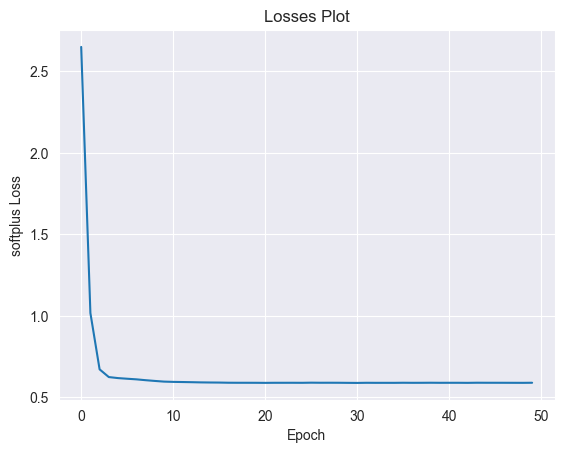

In [25]:
embedding_results.plot_losses()

In [26]:
#import json
#print(json.dumps(embedding_results.metric_results.to_dict(), indent=4))

In [27]:
print(f"Hits@1: {embedding_results.get_metric('hits@1')}")
print(f"Hits@3: {embedding_results.get_metric('hits@3')}")
print(f"Hits@5: {embedding_results.get_metric('hits@5')}")
print(f"Hits@10: {embedding_results.get_metric('hits@10')}")
print(f"Mean Reciprocal Rank: {embedding_results.get_metric('mean_reciprocal_rank')}")
print("Mean Rank:", embedding_results.metric_results.get_metric("mean_rank"))


Hits@1: 6.933777095067418e-05
Hits@3: 0.00021868066222904933
Hits@5: 0.0003786909028844513
Hits@10: 0.0007733828298344428
Mean Reciprocal Rank: 0.0010371963726356626
Mean Rank: 4477.28173828125


# Player Comparison

In [28]:
# Load trained model
model: Model = embedding_results.model  # Extract trained model

# Get entity-to-ID mapping (FIXED)
entity_to_id = embedding_results.training.entity_to_id  # Directly access entity_to_id
id_to_entity = {v: k for k, v in entity_to_id.items()}

# Extract all entity embeddings
embeddings = model.entity_representations[0]().detach().cpu().numpy()

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import re
from rdflib import URIRef

def get_similar_players(player_uri, top_k=5):
    """Finds the most similar players using a two-step approach:
    1. Extracts the top 20 most similar players by cosine similarity.
    2. Filters the top_k most similar players based on weighted similarity."""
    
    # Extract base player ID (remove FIFA version, e.g., "138830_22" → "138830")
    match = re.search(r'Player_(\d+)_\d+', player_uri)
    base_player_id = match.group(1) if match else None
    
    # Ensure the player exists in entity_to_id
    if player_uri not in entity_to_id:
        print(f"Player {player_uri} not found in embeddings.")
        return []
    
    # Extract queried player details
    queried_player_name = "Unknown"
    queried_player_age, queried_player_position, queried_player_physic = "N/A", "N/A", "N/A"
    queried_player_mentality, queried_player_work_rate, queried_player_overall = "N/A", "N/A", "N/A"

    for p, o in g.predicate_objects(URIRef(player_uri)):
        if str(p) == str(BASE + "name"):
            queried_player_name = str(o)
        elif str(p) == str(BASE + "age"):
            queried_player_age = int(o)  
        elif str(p) == str(BASE + "position_category"):
            queried_player_position = str(o)
        elif str(p) == str(BASE + "physic"):
            queried_player_physic = int(o)  
        elif str(p) == str(BASE + "mentality_composure"):
            queried_player_mentality = int(o)  
        elif str(p) == str(BASE + "work_rate"):
            queried_player_work_rate = str(o)  
        elif str(p) == str(BASE + "overall"):
            queried_player_overall = int(o)  

    player_idx = entity_to_id[player_uri]
    player_embedding = embeddings[player_idx].reshape(1, -1)

    # Compute cosine similarity
    similarities = cosine_similarity(player_embedding, embeddings)[0]

    # Weights for each component
    w_cosine = 0.40
    w_position = 0.25
    w_physic = 0.15
    w_mentality = 0.10
    w_work_rate = 0.10

    # Sort by cosine similarity (highest first) and take top 20
    similar_indices = np.argsort(similarities)[::-1]
    top_cosine_candidates = 20 if top_k <= 20 else top_k  # Ensure minimum 20 candidates
    similar_players = []

    for idx in similar_indices[:top_cosine_candidates]:
        candidate_uri = id_to_entity[idx]
        match = re.search(r'Player_(\d+)_\d+', candidate_uri)
        candidate_base_id = match.group(1) if match else None

        # Extract candidate player details
        player_name, player_age, player_position = "Unknown", "N/A", "N/A"
        player_physic, player_mentality, player_work_rate, player_overall = "N/A", "N/A", "N/A", "N/A"

        for p, o in g.predicate_objects(URIRef(candidate_uri)):
            if str(p) == str(BASE + "name"):
                player_name = str(o)
            elif str(p) == str(BASE + "age"):
                player_age = int(o)  
            elif str(p) == str(BASE + "position_category"):
                player_position = str(o)
            elif str(p) == str(BASE + "physic"):
                player_physic = int(o)  
            elif str(p) == str(BASE + "mentality_composure"):
                player_mentality = int(o)  
            elif str(p) == str(BASE + "work_rate"):
                player_work_rate = str(o)  
            elif str(p) == str(BASE + "overall"):
                player_overall = int(o)  

        # **Weighted Similarity Calculation**
        cosine_score = similarities[idx]

        # Position similarity (1 if same, 0 otherwise)
        position_score = 1 if queried_player_position == player_position else 0

        # Physical similarity (normalized difference)
        physic_diff = abs(int(queried_player_physic) - int(player_physic))
        physic_score = 1 - (physic_diff / 100)  

        # Mentality similarity (normalized difference)
        mentality_diff = abs(int(queried_player_mentality) - int(player_mentality))
        mentality_score = 1 - (mentality_diff / 100)  

        # Work Rate similarity (1 if same, 0 otherwise)
        work_rate_score = 1 if queried_player_work_rate == player_work_rate else 0

        # Final weighted similarity score
        weighted_score = (
            w_cosine * cosine_score +
            w_position * position_score +
            w_physic * physic_score +
            w_mentality * mentality_score +
            w_work_rate * work_rate_score
        )

        # Exclude same player versions and ensure entity is a player
        if candidate_base_id and candidate_base_id != base_player_id and candidate_uri.startswith((BASE + "Player_")):
            similar_players.append((candidate_uri, player_name, player_age, player_position, player_physic, player_mentality, player_work_rate, player_overall, cosine_score, weighted_score))

    # Sort players by weighted similarity and extract final top_k players
    similar_players = sorted(similar_players, key=lambda x: x[-1], reverse=True)[:top_k]

    # Print the results
    print("Most Similar Players to:")
    print(f"{queried_player_name} (Age: {queried_player_age}, Position: {queried_player_position}, Physical: {queried_player_physic}, Mentality: {queried_player_mentality}, Work Rate: {queried_player_work_rate}, Overall: {queried_player_overall})\n")
    
    print(f"{'Name':<30} {'Age':<5} {'Position':<10} {'Physic':<8} {'Mentality':<10} {'Work Rate':<12} {'Overall':<8} {'Cosine Sim':<12} {'Weighted Sim':<10}")
    print("-" * 150)
    for uri, name, age, position, physic, mentality, work_rate, overall, cosine_score, weighted_score in similar_players:
        print(f"{name:<30} {age:<5} {position:<10} {physic:<8} {mentality:<10} {work_rate:<12} {overall:<8} {cosine_score:.4f}       {weighted_score:.4f}")

    return similar_players


In [63]:
query_player = BASE + "Player_222665_23"  # Example FIFA 22 player

similar_players = get_similar_players(query_player, 10)


🔍 Most Similar Players to:
🎯 Martin Ødegaard (Age: 23, Position: MID, Physical: 63, Mentality: 78, Work Rate: High/Medium, Overall: 84)

Name                           Age   Position   Physic   Mentality  Work Rate    Overall  Cosine Sim   Weighted Sim
------------------------------------------------------------------------------------------------------------------------------------------------------
Fabián Ruiz Peña               24    MID        68       77         Medium/Medium 82       0.9979       0.8907
Saša Lukić                     24    MID        68       76         Medium/Medium 75       0.9980       0.8897
Ryan Jiro Gravenberch          18    MID        63       65         Medium/Medium 71       0.9980       0.8862
Denis Athanase Bouanga         26    MID        69       72         High/High    76       0.9980       0.8842
Pierre Lees-Melou              29    MID        74       77         High/High    75       0.9986       0.8819
Andri Fannar Baldursson        20    MID  